#Implémentation de DQN et de DDQN avec NN





##Library

In [ ]:
import gymnasium as gym
import math
import random
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from itertools import zip_longest

## Fix seed function

In [ ]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def set_seed(seed):
    """
    Fixe la graine pour initialiser les générateurs de nombres aléatoires.

    Args:
    - seed (int): La valeur de la graine à utiliser pour l'initialisation des générateurs aléatoires.

    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

# Define Transition namedtuple
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

## Define ReplayMemory class

In [ ]:


class ReplayMemory:
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

## Define the DQN class

In [ ]:


class DQN(nn.Module):
    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

## Helper function to select action

In [ ]:

def select_action(state, policy_net, n_actions,steps_done,EPS_START,EPS_END,EPS_DECAY):
    """
    Sélectionne une action à effectuer en utilisant la stratégie epsilon-greedy.
    Args:
    - state (torch.Tensor): L'état actuel de l'environnement.
    - policy_net (nn.Module): Le réseau de politique (Q-network) utilisé pour estimer les valeurs Q des actions.
    - n_actions (int): Le nombre d'actions possibles dans l'environnement.
    - steps_done (int): Le nombre d'étapes effectuées jusqu'à présent, utilisé pour ajuster l'épsilon.
    - EPS_START (float): La valeur initiale de l'épsilon.
    - EPS_END (float): La valeur finale de l'épsilon.
    - EPS_DECAY (float): Le facteur de décroissance de l'épsilon.

    Returns:
    - torch.Tensor: L'action sélectionnée par l'agent sous forme d'un tensor.
    """

    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            return policy_net(state).max(1).indices.view(1, 1)
    else:
        return torch.tensor([[random.randrange(n_actions)]], device=device, dtype=torch.long)


##DDQN and DQN

In [ ]:


def optimize_model(policy_net, target_net, memory, optimizer, BATCH_SIZE, GAMMA, use_ddqn):
    """
    Effectue une étape de mise à jour du modèle.

    Args:
    - policy_net (nn.Module): Le réseau de politique utilisé pour estimer les valeurs Q des actions.
    - target_net (nn.Module): Le réseau cible utilisé pour calculer les valeurs Q cibles.
    - memory (ReplayMemory): La mémoire tampon contenant les transitions passées sous forme de `state`, `action`, `next_state`, `reward`.
    - optimizer (torch.optim.Optimizer): L'optimiseur utilisé pour ajuster les poids du réseau de politique.
    - BATCH_SIZE (int): La taille du lot d'échantillons tirés de la mémoire.
    - GAMMA (float): Le facteur de réduction pour les récompenses futures (paramètre de discount).
    - use_ddqn (bool): Si True, utilise Double DQN (DDQN), sinon utilise le DQN classique.
    """

    if len(memory) < BATCH_SIZE:
        return

    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))

    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Q-values actuelles
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Calcul des Q-values cibles
    next_state_values = torch.zeros(BATCH_SIZE, device=device)

    with torch.no_grad():
        if use_ddqn:
            # DDQN : sélection de l'action avec le réseau principal, évaluation avec le réseau cible
            next_actions = policy_net(non_final_next_states).max(1).indices
            next_state_values[non_final_mask] = target_net(non_final_next_states).gather(1, next_actions.unsqueeze(1)).squeeze(1)
        else:
            # DQN : sélection et évaluation avec le réseau cible
            next_state_values[non_final_mask] = target_net(non_final_next_states).max(1).values

    # Calcul des valeurs cibles
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Calcul de la perte
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimisation
    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()


##plotting

In [ ]:
def pad_sequences(data, fill_value=np.nan):
        """
    Convertit des listes de longueurs variables en un tableau NumPy avec un padding
    pour égaliser les longueurs des séquences.

    Args:
    - data (list of lists): Liste de séquences de longueurs variées à compléter.
    - fill_value (optional, default=np.nan): La valeur de remplissage utilisée pour
      égaliser les séquences plus courtes. Par défaut, cette valeur est NaN.

    Returns:
    - np.ndarray: Un tableau NumPy contenant les séquences égalisées avec le padding.
    """

    return np.array(list(zip_longest(*data, fillvalue=fill_value))).T


# Function to plot the results
def plot_results(scores_dqn_runs, scores_ddqn_runs, q_values_dqn_run, q_values_ddqn_run, num_episodes):
    """
    Affiche les résultats d'entraînement pour les modèles DQN et DDQN, y compris les scores et les Q-values,
    avec des courbes de médiane et des intervalles de confiance (25e et 75e percentiles).

    Cette fonction génère deux graphiques côte à côte :
    - Le premier montre l'évolution des scores de performance de l'agent DQN et DDQN, avec des intervalles de confiance.
    - Le deuxième affiche les Q-values médianes des deux modèles avec des intervalles de confiance.

    Args:
    - scores_dqn_runs (list of list): Scores des différentes exécutions pour le modèle DQN. Chaque sous-liste correspond
      aux scores d'une exécution.
    - scores_ddqn_runs (list of list): Scores des différentes exécutions pour le modèle DDQN. Chaque sous-liste correspond
      aux scores d'une exécution.
    - q_values_dqn_run (list of list): Q-values au cours de l'entraînement pour le modèle DQN. Chaque sous-liste correspond
      aux Q-values d'une exécution.
    - q_values_ddqn_run (list of list): Q-values au cours de l'entraînement pour le modèle DDQN. Chaque sous-liste correspond
      aux Q-values d'une exécution.

    """
    # Appliquer le padding aux Q-values
    q_values_dqn_run = pad_sequences(q_values_dqn_run)
    q_values_ddqn_run = pad_sequences(q_values_ddqn_run)
    #scores
    median_dqn = np.median(scores_dqn_runs, axis=0)
    lower_dqn = np.percentile(scores_dqn_runs, 25, axis=0)
    upper_dqn = np.percentile(scores_dqn_runs, 75, axis=0)

    median_ddqn = np.median(scores_ddqn_runs, axis=0)
    lower_ddqn = np.percentile(scores_ddqn_runs, 25, axis=0)
    upper_ddqn = np.percentile(scores_ddqn_runs, 75, axis=0)
    #q_values

    # Calculer les médianes en ignorant les NaN
    median_dqn_q = np.nanmedian(q_values_dqn_run, axis=0)
    lower_dqn_q = np.nanpercentile(q_values_dqn_run, 25, axis=0)
    upper_dqn_q = np.nanpercentile(q_values_dqn_run, 75, axis=0)

    median_ddqn_q = np.nanmedian(q_values_ddqn_run, axis=0)
    lower_ddqn_q = np.nanpercentile(q_values_ddqn_run, 25, axis=0)
    upper_ddqn_q = np.nanpercentile(q_values_ddqn_run, 75, axis=0)

    # Tronquer les Q-values pour qu'elles aient la même longueur que num_episodes
    median_dqn_q = median_dqn_q[:num_episodes]
    lower_dqn_q = lower_dqn_q[:num_episodes]
    upper_dqn_q = upper_dqn_q[:num_episodes]

    median_ddqn_q = median_ddqn_q[:num_episodes]
    lower_ddqn_q = lower_ddqn_q[:num_episodes]
    upper_ddqn_q = upper_ddqn_q[:num_episodes]

    fig, axs = plt.subplots(1, 2, figsize=(16, 6))  # 1 ligne, 2 colonnes

    # Premier graphe : Scores
    axs[0].plot(median_dqn, label='DQN Median')
    axs[0].fill_between(range(num_episodes), lower_dqn, upper_dqn, alpha=0.2)
    axs[0].plot(median_ddqn, label='DDQN Median')
    axs[0].fill_between(range(num_episodes), lower_ddqn, upper_ddqn, alpha=0.2)
    axs[0].set_title('Scores')
    axs[0].set_xlabel('Episodes')
    axs[0].set_ylabel('Scores')
    axs[0].legend()

    # Deuxième graphe : Q-values
    axs[1].plot(median_dqn_q, label='DQN Median Q-value')
    axs[1].fill_between(range(num_episodes), lower_dqn_q, upper_dqn_q, alpha=0.2)
    axs[1].plot(median_ddqn_q, label='DDQN Median Q-value')
    axs[1].fill_between(range(num_episodes), lower_ddqn_q, upper_ddqn_q, alpha=0.2)
    axs[1].set_title('Q-values')
    axs[1].set_xlabel('Episodes')
    axs[1].set_ylabel('Q-values')
    axs[1].legend()

    # Ajuster l'espacement
    plt.tight_layout()
    plt.show()


##train data

In [ ]:
def train_episode(env, policy_net, target_net, optimizer, memory, n_actions, steps_done, EPS_START, EPS_END, EPS_DECAY, BATCH_SIZE, GAMMA, TAU, use_ddqn):
    """
    Effectue une seule itération d'entraînement sur un épisode en interagissant avec l'environnement.

    Args:
    - env (gym.Env): L'environnement dans lequel l'agent interagit.
    - policy_net (nn.Module): Le réseau de politique utilisé pour sélectionner les actions.
    - target_net (nn.Module): Le réseau cible utilisé pour calculer les valeurs Q cibles.
    - optimizer (torch.optim.Optimizer): L'optimiseur utilisé pour ajuster les poids du réseau de politique.
    - memory (ReplayMemory): La mémoire tampon contenant les transitions sous forme de `state`, `action`, `next_state`, `reward`.
    - n_actions (int): Le nombre d'actions possibles dans l'environnement.
    - steps_done (int): Le nombre total d'étapes effectuées jusqu'à présent (utilisé pour calculer epsilon).
    - EPS_START (float): La valeur initiale de epsilon pour l'exploration.
    - EPS_END (float): La valeur finale de epsilon pour l'exploration.
    - EPS_DECAY (float): Le taux de décadence de epsilon.
    - BATCH_SIZE (int): La taille du lot d'échantillons tirés de la mémoire pour l'optimisation.
    - GAMMA (float): Le facteur de réduction des récompenses futures (paramètre de discount).
    - TAU (float): Le taux de mise à jour du réseau cible.
    - use_ddqn (bool): Si True, utilise Double DQN (DDQN), sinon utilise DQN classique.

    Returns:
    - total_reward (float): La récompense totale obtenue pendant l'épisode.
    - q_values (list of float): Une liste des valeurs Q pour chaque état pendant l'épisode.
    """

    state, _ = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)

    total_reward = 0
    q_values = []

    for t in count():

        action = select_action(state, policy_net, n_actions, steps_done, EPS_START, EPS_END, EPS_DECAY)

        observation, reward, terminated, truncated, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated
        next_state = None if terminated else torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        memory.push(state, action, next_state, reward)

        state = next_state
        total_reward += reward.item()

        if len(memory) >= BATCH_SIZE:
            optimize_model(policy_net, target_net, memory, optimizer, BATCH_SIZE, GAMMA, use_ddqn)

        # θ′ ← τ θ + (1 − τ)θ′
        with torch.no_grad():
            for target_param, policy_param in zip(target_net.parameters(), policy_net.parameters()):
                target_param.data.copy_(policy_param.data * TAU + target_param.data * (1.0 - TAU))

        with torch.no_grad():
            if state is not None:
                q_value = policy_net(state).max(1)[0].item()
                q_values.append(q_value)

        if done:
            break

    return total_reward, q_values


## Training and plotting function

In [ ]:

def train_and_plot(env_name, num_episodes, num_runs, steps_done, EPS_START, EPS_END, EPS_DECAY, BATCH_SIZE, GAMMA,TAU):
    """
    Entraîne un agent avec DQN et DDQN sur plusieurs épisodes et exécutions, puis trace les résultats.

    Args:
    - env_name (str): Le nom de l'environnement Gym dans lequel l'agent sera entraîné.
    - num_episodes (int): Le nombre d'épisodes à exécuter pour chaque exécution.
    - num_runs (int): Le nombre total d'exécutions pour entraîner et évaluer l'agent.
    - steps_done (int): Le nombre total d'étapes effectuées, utilisé pour ajuster epsilon dans la stratégie epsilon-greedy.
    - EPS_START (float): La valeur initiale de epsilon pour l'exploration.
    - EPS_END (float): La valeur finale de epsilon pour l'exploration.
    - EPS_DECAY (float): Le taux de décroissance de epsilon.
    - BATCH_SIZE (int): La taille des lots pour l'optimisation du modèle.
    - GAMMA (float): Le facteur de réduction des récompenses futures.
    - TAU (float): Le taux de mise à jour des paramètres du réseau cible.
    """

    env = gym.make(env_name)
    n_actions = env.action_space.n
    n_observations = env.observation_space.shape[0]

    scores_dqn_runs, scores_ddqn_runs = [], []
    q_values_dqn_run, q_values_ddqn_run = [], []

    for run in range(num_runs):
        print(f"Run: {run+1}/{num_runs}")
        set_seed(run)

        # Initialisation des réseaux pour DQN
        policy_net_dqn = DQN(n_observations, n_actions).to(device)
        target_net_dqn = DQN(n_observations, n_actions).to(device)
        target_net_dqn.load_state_dict(policy_net_dqn.state_dict())
        target_net_dqn.eval()
        optimizer_dqn = optim.AdamW(policy_net_dqn.parameters(), lr=1e-4, amsgrad=True)
        memory_dqn = ReplayMemory(10000)

        # Initialisation des réseaux pour DDQN
        policy_net_ddqn = DQN(n_observations, n_actions).to(device)
        target_net_ddqn = DQN(n_observations, n_actions).to(device)
        target_net_ddqn.load_state_dict(policy_net_ddqn.state_dict())
        target_net_ddqn.eval()
        optimizer_ddqn = optim.AdamW(policy_net_ddqn.parameters(), lr=1e-4, amsgrad=True)
        memory_ddqn = ReplayMemory(10000)

        scores_dqn, scores_ddqn = [], []
        q_values_dqn, q_values_ddqn = [], []

        # Entraînement DQN et DDQN
        for i_episode in range(num_episodes):
            # Entraînement DQN
            dqn_score, dqn_q_values = train_episode(env, policy_net_dqn, target_net_dqn, optimizer_dqn, memory_dqn, n_actions, steps_done, EPS_START, EPS_END, EPS_DECAY, BATCH_SIZE, GAMMA,TAU ,use_ddqn=False)
            scores_dqn.append(dqn_score)
            q_values_dqn.extend(dqn_q_values)

            # Entraînement DDQN
            ddqn_score, ddqn_q_values = train_episode(env, policy_net_ddqn, target_net_ddqn, optimizer_ddqn, memory_ddqn, n_actions, steps_done, EPS_START, EPS_END, EPS_DECAY, BATCH_SIZE, GAMMA,TAU, use_ddqn=True)
            scores_ddqn.append(ddqn_score)
            q_values_ddqn.extend(ddqn_q_values)

        scores_dqn_runs.append(scores_dqn)
        scores_ddqn_runs.append(scores_ddqn)
        q_values_dqn_run.append(q_values_dqn)
        q_values_ddqn_run.append(q_values_ddqn)

    # Plotting
    plot_results(scores_dqn_runs, scores_ddqn_runs, q_values_dqn_run, q_values_ddqn_run, num_episodes)


#Test CartPole-v1 and Acorabate

Testing CartPole-v1...
Run: 1/10
Run: 2/10
Run: 3/10
Run: 4/10
Run: 5/10
Run: 6/10
Run: 7/10
Run: 8/10
Run: 9/10
Run: 10/10


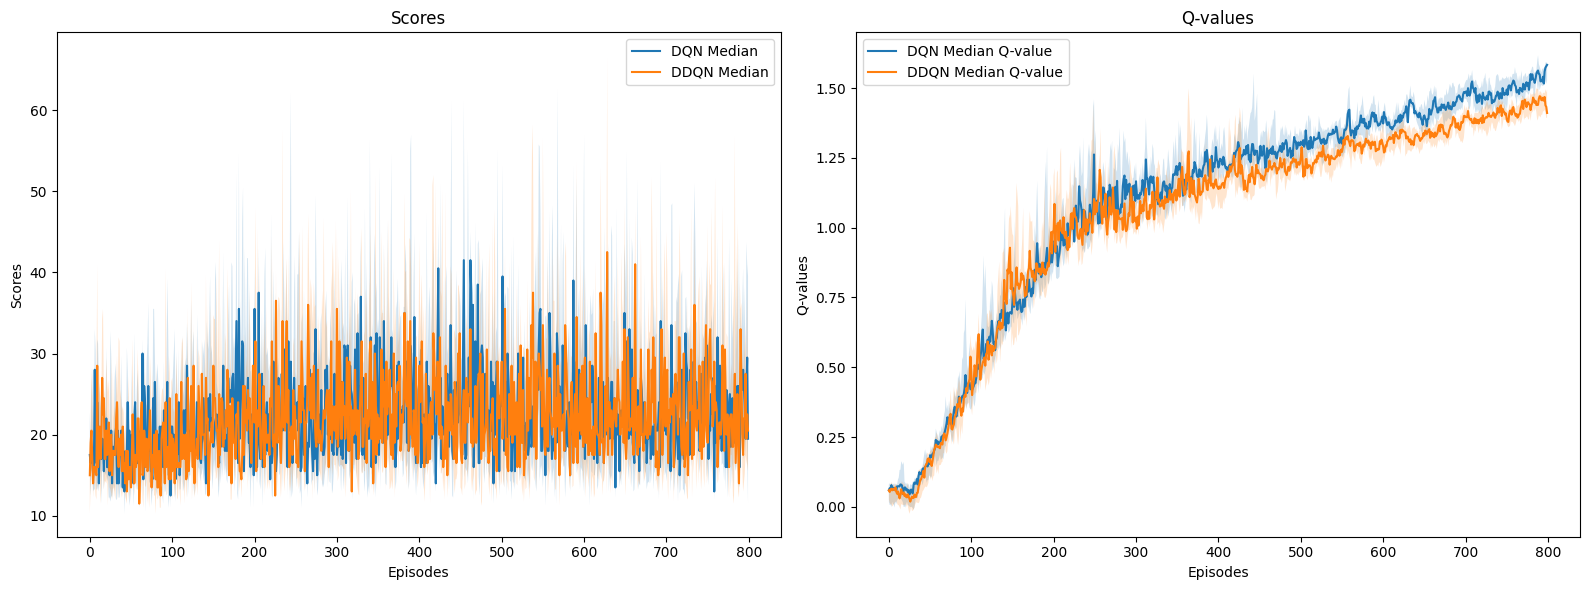

In [ ]:
print("Testing CartPole-v1...")
#train_and_plot(env_name, num_episodes, num_runs,steps_done,EPS_START,EPS_END,EPS_DECAY,BATCH_SIZE,GAMMA):
train_and_plot(
    env_name="CartPole-v1",
    num_episodes=800,
    num_runs=10,
    steps_done = 0,
    EPS_START=0.9,
    EPS_END=0.05,
    EPS_DECAY=1000,
    BATCH_SIZE=32,
    GAMMA=0.99,
    TAU=0.001
)

In [ ]:
train_and_plot(
    env_name="Acrobate-v1",
    num_episodes=100,
    num_runs=5,
    steps_done = 0,
    EPS_START=0.9,
    EPS_END=0.05,
    EPS_DECAY=5000,
    BATCH_SIZE=132,
    GAMMA=0.99,
    TAU=0.005
)